In [99]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn import svm
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import normalize

from matplotlib import pyplot as plt
%matplotlib inline

inputFolder='../data/'
trainFolder=inputFolder+'train/'
testFolder=inputFolder+'test/'

In [100]:
trainUsers=pd.read_csv(trainFolder+'user_info_train.txt', \
                           names=['id','sex','profession','education','marriage','citizen_type'],\
                          index_col=0)

trainBanks=pd.read_csv(trainFolder+'bank_detail_train.txt',\
                          names=['user_id', 'time', 'transaction_type', 'amount', 'is_salary'])

trainBrowse=pd.read_csv(trainFolder+'browse_history_train.txt',\
                           names=['user_id', 'time', 'browse_type', 'sub_type'])

trainBills=pd.read_csv(trainFolder+'bill_detail_train.txt',\
                          names=['user_id', 'time', 'bank_id', 'last_bill_amount', 'last_bill_pay', 'credit_line', 'cur_bill_balance', 'cur_bill_min_due', 'transactionNum', 'cur_bill_amount', 'adjusted_amount', 'cumulative_interest', 'available_deposit', 'available_credit', 'debt_status'])

trainFundingTime=pd.read_csv(trainFolder+'loan_time_train.txt',\
                                names=['user_id', 'time'])

trainOverdue=pd.read_csv(trainFolder+'overdue_train.txt',\
                            names=['user_id', 'label'], index_col=0)

In [101]:
userFeatures=trainUsers.copy()

bankRecordsPersonal=trainBanks.groupby('user_id')
userFeatures['transactionNum']=bankRecordsPersonal['amount'].count().astype(int)
userFeatures['transactionAmount']=bankRecordsPersonal['amount'].sum()
userFeatures['salaryNum']=bankRecordsPersonal['is_salary'].sum().astype(int)

browseRecordsPersonal=trainBrowse.groupby('user_id')
userFeatures['browseNum']=browseRecordsPersonal['time'].count().astype(int)
userFeatures['browseTypes']=browseRecordsPersonal['browse_type'].nunique().astype(int)
userFeatures['browseSubTypes']=browseRecordsPersonal.apply(lambda x: x.groupby('browse_type')['sub_type'].nunique().sum()).astype(int)

bills=trainBills.groupby('user_id')
userFeatures['billBanksNum']=bills['bank_id'].nunique().astype(int)
userFeatures['billNum']=bills['time'].count().astype(int)

In [102]:
userFeatures['transactionNum'].fillna(0, inplace=True)
userFeatures['salaryNum'].fillna(0, inplace=True)
# userFeatures['browseNum'].fillna(0, inplace=True)
userFeatures['browseTypes'].fillna(0, inplace=True)
userFeatures['browseSubTypes'].fillna(0, inplace=True)
userFeatures['billBanksNum'].fillna(0, inplace=True)
userFeatures['billNum'].fillna(0, inplace=True)


userFeatures['transactionNum']=userFeatures['transactionNum'].astype(int)
userFeatures['salaryNum']=userFeatures['salaryNum'].astype(int)
# userFeatures['browseNum']=userFeatures['browseNum'].astype(int)
userFeatures['browseTypes']=userFeatures['browseTypes'].astype(int)
userFeatures['browseSubTypes']=userFeatures['browseSubTypes'].astype(int)
userFeatures['billBanksNum']=userFeatures['billBanksNum'].astype(int)
userFeatures['billNum']=userFeatures['billNum'].astype(int)

userFeatures['transactionAmount'].fillna(0, inplace=True)
print userFeatures.head()

      sex  profession  education  marriage  citizen_type  transactionNum  \
id                                                                         
3150    1           2          4         1             4               0   
6965    1           2          4         3             2             364   
1265    1           3          4         3             1             419   
6360    1           2          4         3             2               0   
2583    2           2          2         1             1             831   

      transactionAmount  salaryNum  browseNum  browseTypes  browseSubTypes  \
id                                                                           
3150           0.000000          0        NaN            0               0   
6965        4207.382203          0     1710.0           39              39   
1265        5370.663258          0      420.0           17              17   
6360           0.000000          0      225.0            9               9   

In [103]:
userFeatures.sort_index(inplace=True)
trainOverdue.sort_index(inplace=True)

In [104]:
def convert2Dummies(df, cln):
    dummies=pd.get_dummies(df[cln]).astype(int)
    dummies.columns=[cln+`c` for c in dummies.columns]

    return pd.concat([df, dummies], axis=1)

In [105]:
userFeatures=convert2Dummies(userFeatures, 'sex')
userFeatures=convert2Dummies(userFeatures, 'profession')
userFeatures=convert2Dummies(userFeatures, 'education')
userFeatures=convert2Dummies(userFeatures, 'marriage')
userFeatures=convert2Dummies(userFeatures, 'citizen_type')


(array([  5.11190000e+04,   2.69400000e+03,   1.01900000e+03,
          4.56000000e+02,   2.13000000e+02,   5.50000000e+01,
          2.20000000e+01,   8.00000000e+00,   4.00000000e+00,
          3.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00]),
 array([      0.        ,    6095.95994705,   12191.9198941 ,
          18287.87984115,   24383.8397882 ,   30479.79973525,
          36575.7596823 ,   42671.71962935,   48767.6795764 ,
          54863.63952345,   60959.5994705 ,   67055.55941755,
          73151.5193646 ,   79247.47931165,   85343.4392587 ,
          91439.39920575,   97535.3591528 ,  103631.31909985,
         109727.2790469 ,  115823.23899395,  121919.198941  ]),
 <a list of 20 Patch objects>)

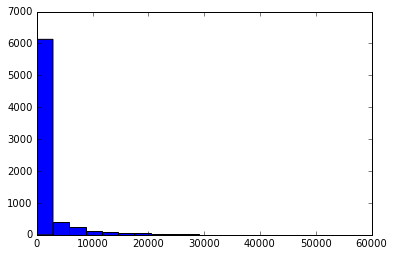

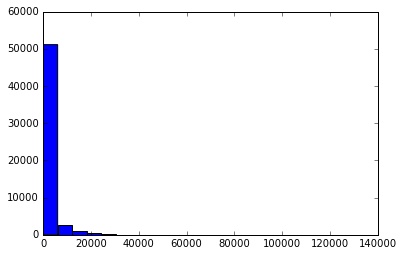

In [159]:
overdueAmount=userFeatures['transactionAmount'].values[trainOverdue.values.ravel()==1]
plt.hist(overdueAmount, bins=20)
plt.figure()
plt.hist(userFeatures['transactionAmount'].values, bins=20)

In [106]:
print userFeatures.head()

    sex  profession  education  marriage  citizen_type  transactionNum  \
id                                                                       
1     1           2          3         1             3              86   
2     1           2          3         2             1               0   
3     1           4          4         1             4             679   
4     1           4          4         3             2             291   
5     1           2          2         3             1               0   

    transactionAmount  salaryNum  browseNum  browseTypes      ...        \
id                                                            ...         
1         1156.718031          0        NaN            0      ...         
2            0.000000          0     1305.0           24      ...         
3         7264.831053          0      342.0           15      ...         
4         3293.768106          0      364.0           17      ...         
5            0.000000          

In [96]:
byFeatures=userFeatures.copy()
byFeatures['label']=trainOverdue['label']

crit='billNum'
result=pd.DataFrame({'count': byFeatures.groupby(crit)['label'].count(), \
'mean': byFeatures.groupby(crit)['label'].mean()})
# print result


In [107]:

X=userFeatures.values
imp=Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
X=imp.fit_transform(X)
y=trainOverdue.values.ravel()

In [95]:
print X.shape
print y.shape

(5, 27)
(55596,)


In [142]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2)
weights=y_train+1

In [143]:
clf=rfc(n_estimators=600, max_depth=None, n_jobs=4, min_samples_split=4, random_state=0)
clf.fit(X_train, y_train, sample_weight=weights)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=4, min_weight_fraction_leaf=0.0,
            n_estimators=600, n_jobs=4, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [144]:
clf.score(X_test, y_test)

0.86807553956834538

In [145]:
pred=clf.predict_proba(X_test)[:,1]

In [71]:
p=clf.predict(X)

In [146]:
print len(pred[pred>0.5])
print 1.0*sum(y_test)/len(y_test)
print sum(y_test)
print sum(y_train)
print 1.0*len(pred[(pred>0.5)&(y_test==1)])/sum(y_test==1)

238
0.125809352518
1399
5784
0.06075768406


In [74]:
print 1.0*sum((p==y)&(y==1))/sum(y)

0.676179869135


In [ ]:
svm_clf=svm.SVC(kernel='linear', C=1).fit(X_train, y_train)